# Visualize nucleotide importance score predictions and experimental outcomes of the mutagenesis pair
Required inputs:
* `activity_summary_stats_and_metadata.txt`
* `blocks.txt`: The names of the two sequences and a list of zero-based positions indicating where the blocks start.
* `swap_coords.txt`: Metadata for the designed swaps between two sequences.
* `slide_coords.txt`: Metadata for sliding the NRL motif along the strong enhancer.
* `eLifeMotifs.meme`
* Regression CNN

Additional input: The HOCOMOCO database v11 for the core set of mouse motifs.

Expected outputs:
* `representativePair{StrongEnhancer,Inactive}.svg`: Cartoon diagrams of the strong enhancer and inactive sequence.
* `{strongEnhancer,Inactive}SaliencyActual.svg`: The saliency maps for the two sequences.
* `strongEnhancerScramblesBarplot.svg`: The observed effect of scrambling various parts of the strong enhancer.
* `inactiveSwapsCombinedBarplot.svg` and `inactiveSwapsCartoons.svg`: The observed effect of swapping various parts of the strong enhancer into the inactive sequence, and cartoons of the sequences.
* `inactiveSwapSaliencyActual.svg` and `inactiveSwapMotifImportance.svg`: The saliency map of the inactive sequence when positions 86-136 of the strong enhancer are swapped in, and quantification of the importance of the motifs before and after the swap.
* `strongEnhancerSlideNrl.svg`: The observed effect of sliding the NRL motif along the strong enhancer.
* `strongEnhancerSlideNrlImportance.svg`: The predicted importance of the NRL and the NR1D1 motif when the NRL motif is slid along the strong enhancer.
* `strongEnhancerSlideSaliencyZoom.svg`: Saliency maps of positions 120-140 in the strong enhancer when the NRL motif is inserted at positions 126-130.
* `motif_NR1D1_F_119.svg`: The NR1D1 PWM and the sequence that it matches to. Extra outputs are other motifs in the database that match within the region.

In [1]:
import os
import sys
import re

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import logomaker

from src.mpra_tools import deeplift_utils, loaders, predicted_occupancy, plot_utils
from src.selene_files.enhancer_resnet_regression import EnhancerResnet

data_dir = "Data"
figures_dir = "Figures"
plot_utils.set_manuscript_params()

/ref/bclab/software/ryan/.conda/envs/active-learning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load in all data and extract activity for anything in the swaps.

In [2]:
L = 164
model = loaders.load_cnn(
    os.path.join("ModelFitting", "CNN_Reg", "best_model", "best_model.pth.tar"),
    model=EnhancerResnet(L),
    eval_mode=True,
)
blocks = loaders.load_data(
    os.path.join("Data", "Swaps", "blocks.txt"),
    header=None,
).squeeze()
swap_coords = loaders.load_data(
    os.path.join("Data", "Swaps", "swap_coords.txt"),
    index_col=None,
)
slide_coords = loaders.load_data(
    os.path.join("Data", "Swaps", "slide_coords.txt")
)
activity_df = loaders.load_data(
    os.path.join(data_dir, "activity_summary_stats_and_metadata.txt")
)
swap_pair_mask = activity_df["label"].isin(
    pd.concat([swap_coords["label"], slide_coords["label"]])
)
activity_df = activity_df[swap_pair_mask]
sequences = activity_df.set_index("label")["sequence"].drop_duplicates()

ewms = predicted_occupancy.read_pwm_to_ewm(
    os.path.join("Data", "Downloaded", "eLifeMotifs.meme")
).rename(lambda x: x.split("_")[0])
mu = 9

/ref/bclab/software/ryan/.conda/envs/active-learning/lib/python3.9/site-packages/torch/nn/modules/lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Visualizing the evil twin pair.

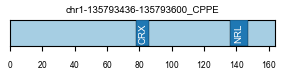

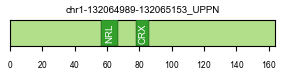

In [3]:
strong_enhancer_id = blocks["strong_enhancer_label"]
inactive_id = blocks["inactive_label"]
block_starts = blocks["block_start_coords"]
strong_enhancer_wt_seq = sequences[strong_enhancer_id + "_WT"]
inactive_wt_seq = sequences[inactive_id + "_WT"]

light_blue = (166/255, 206/255, 227/255)
dark_blue = (31/255, 120/255, 180/255)
light_green = (178/255, 223/255, 138/255)
dark_green = (51/255, 160/255, 44/255)

fig, ax = plot_utils.visualize_sequence(
    strong_enhancer_wt_seq,
    light_blue,
    ewms,
    mu,
    dark_blue,
    above_text=strong_enhancer_id,
)
plot_utils.save_fig(fig, os.path.join(figures_dir, "representativePairStrongEnhancer"))
fig, ax = plot_utils.visualize_sequence(
    inactive_wt_seq,
    light_green,
    ewms,
    mu,
    dark_green,
    above_text=inactive_id,
)
plot_utils.save_fig(fig, os.path.join(figures_dir, "representativePairInactive"))

Saliency maps of WT sequences.

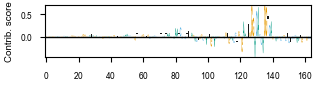

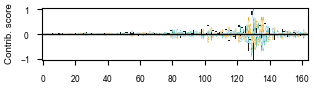

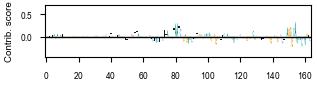

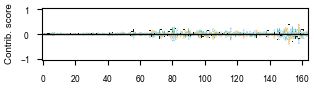

In [4]:
ylims = (-0.4643346071243286, 0.7107071876525879)

for seq, name in [[strong_enhancer_wt_seq, "strongEnhancer"], [inactive_wt_seq, "inactive"]]:
    hypo, actual, pred = deeplift_utils.saliency_map(seq, model)
    fig, ax = plot_utils.plot_deeplift(
        actual,
    )
    ax.set_ylim(ylims)
    # print(ax.get_ylim())
    plot_utils.save_fig(fig, os.path.join(figures_dir, name + "SaliencyActual"))
    
    # Hypothetical contributions
    fig, ax = plot_utils.plot_deeplift(
        hypo,
    )
    ax.set_ylim((-1.072474181652069, 1.072474181652069))
    # print(ax.get_ylim())

## Experimental results

Spacer scrambles in strong enhancer.

{78: 'CRX_F', 136: 'NRL_R'}


,mean,std,count
decoding,,,
WT,4.089539,0.658928,4
"Crx_F,Nrl_R",1.305648,NaN,1
"[0,20)",3.439091,0.342810,5
"[10,30)",3.371809,0.185185,5
"[20,40)",3.489333,0.214927,5
"[30,50)",3.468805,0.611871,5
"[40,60)",3.545690,0.220500,5
"[50,70)",3.318595,0.354918,5
"[55,75)",3.993229,0.223562,5


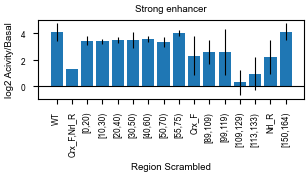

In [5]:
def _decode_block(x):
    begin, end = x.split("-")
    return (int(begin), int(end))

def decode_blocks(coords):
    return [_decode_block(x) for x in coords]

# Determine if a pair of coordinates are adjacent, and if so, merge them
def join_coords(coords):
    new_coords = []
    begin = coords[0][0]
    for i in range(len(coords) - 1):
        current = coords[i + 1]
        previous = coords[i]
        # End of a block!
        if previous[1] != current[0]:
            new_coords.append((begin, previous[1]))
            begin = current[0]
            
    # Check if we closed off the block
    last = coords[-1][1]
    if len(new_coords) == 0 or new_coords[-1][1] != coords[-1][1]:
        new_coords.append((begin, last))
    
    return new_coords

def coord_string(coords, site_map, offset, max_block_size=None):
    shift = coords[0] + offset
    if shift in site_map.keys():
        tf, strand = site_map[shift].split("_")
        result = tf.capitalize() + "_" + strand
    else:
        begin, end = coords
        if max_block_size and (end - begin > max_block_size):
            result = ""
        else:
            result = f"[{begin},{end})"
    
    return result

def decode(encoding, site_map):
    coords = re.compile("x(\d+\-\d+)").findall(encoding)
    decoded = decode_blocks(coords)
    if len(coords) > 1:
        decoded = join_coords(decoded)
    n = len(decoded)
    # Now turn each coordinate into a string
    decoded_str = [coord_string(i, site_map, offset=3) for i in decoded]
    decoded_str = ",".join(decoded_str)
    # Blocks longer than 20 bp don't get decoded
    if len(decoded_str) == 0:
        decoded_str = np.nan
    
    return pd.Series({
        "decoding": decoded_str,
        "n_blocks": n,
        "first_start": decoded[0][0] 
    })

scramble_coords = swap_coords[
    (swap_coords["original_seq"] == strong_enhancer_id) &\
    swap_coords["blocks"].str.contains("x")
]

# Get a map of the occupied sites
strong_site_map = predicted_occupancy.get_occupied_sites_and_tfs(
    predicted_occupancy.total_landscape(strong_enhancer_wt_seq, ewms, mu)
)
print(strong_site_map)
# Put the label on the index to facilitate groupby
# Then decode the coordinates into a string
coords_decoded = scramble_coords.set_index("label")["blocks"].apply(decode, args=(strong_site_map,))
# Add in WT
coords_decoded.loc[strong_enhancer_id + "_WT"] = ["WT", np.inf, np.inf]
# Get the measurements
cleaned_labels = activity_df["label"].str.removesuffix("_v2").str.removesuffix("_v3")
pair_activity_df = activity_df[
    activity_df["label"].isin(coords_decoded.index)
].set_index("label")
# Now rename the index to the string decoding
pair_activity_df = pair_activity_df.rename(coords_decoded["decoding"])
# Finally, average across replicate measurements
scrambled_averaged = pair_activity_df.groupby("label")["expression_log2"].agg(["mean", "std", "count"])

# Define a sort order
sort_order = coords_decoded.dropna().set_index(
    "decoding").drop_duplicates().sort_values(
    ["n_blocks", "first_start"], ascending=[False, True]
).index
scrambled_averaged = scrambled_averaged.loc[sort_order]
display(scrambled_averaged)

fig, ax = plt.subplots(figsize=plot_utils.get_figsize(0.5, aspect=0.3))
ax.bar(
    np.arange(len(scrambled_averaged)),
    scrambled_averaged["mean"],
    yerr=scrambled_averaged["std"],
    tick_label=scrambled_averaged.index
)
ax.axhline(0, color="k")
ax.set_xlabel("Region Scrambled")
ax.set_ylabel("log2 Acivity/Basal")
ax.set_title("Strong enhancer")
plot_utils.rotate_ticks(ax.get_xticklabels(), 90)
plot_utils.save_fig(fig, os.path.join(figures_dir, "strongEnhancerScramblesBarplot"))

Swaps into inactive.

Mapping from block letters to coordinates:


A       (0, 56)
B      (56, 67)
C      (67, 78)
D      (78, 86)
E     (86, 136)
F    (136, 147)
G    (147, 164)
dtype: object

{56: 'NRL_F', 78: 'CRX_F'}


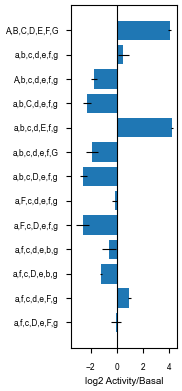

In [6]:
def int_to_lowercase(i):
    return chr(i+97)

def int_to_uppercase(i):
    return chr(i+65)

def get_block_coords(block_str):
    splitter = list(map(int, block_str.split(",")))
    # Append the final position to make code easier
    splitter.append(164)
    block_letter_map = {}
    for i, start in enumerate(splitter[:-1]):
        block_id = int_to_uppercase(i)
        block_letter_map[block_id] = (start, splitter[i+1])
    
    return pd.Series(block_letter_map)

def decode_swapped_block(x, decoder):
    return decoder[x]

block_coords = get_block_coords(block_starts)
print("Mapping from block letters to coordinates:")
display(block_coords)

# Get the inactive site map
inactive_site_map = predicted_occupancy.get_occupied_sites_and_tfs(
    predicted_occupancy.total_landscape(inactive_wt_seq, ewms, mu)
)
print(inactive_site_map)

inactive_swaps = swap_coords[swap_coords["original_seq"] == inactive_id]
# Only plot the single spacer swaps, or the motif swaps, or the WT sequences. No combinations of spacers
inactive_swaps = inactive_swaps[
    # Only one block swapped
    (inactive_swaps["blocks"].str.count("[A-Z]") <= 1) |\
    # Things involving NRL
    ~(inactive_swaps["blocks"].str.lower().str.match("a,b,c,d,e,f,g"))
]
# Add in the WT strong enhancers as reference
inactive_swaps = pd.concat([
    inactive_swaps,
    swap_coords[swap_coords["label"] == strong_enhancer_id + "_WT"]
])

# Join with activity measurements, only keep the first instance of the SE
swaps_activity = activity_df.set_index("label").join(
    inactive_swaps.set_index("label").drop(columns="original_seq"),
    how="inner",
)
swaps_activity = swaps_activity[~swaps_activity.index.duplicated(keep="first")]
# Manually arrange the order to display in -- I'm doing it in the order it will actually display, but to display it in that order, it will then be reversed
swaps_activity = swaps_activity.reset_index().set_index("blocks")
swaps_activity = swaps_activity.loc[[
    # WT strong enhancer
    "A,B,C,D,E,F,G",
    # WT inactive
    "a,b,c,d,e,f,g",
    # Spacer swaps
    "A,b,c,d,e,f,g",
    "a,b,C,d,e,f,g",
    "a,b,c,d,E,f,g",
    "a,b,c,d,e,f,G",
    # Motifs
    "a,b,c,D,e,f,g",
    "a,F,c,d,e,f,g",
    "a,F,c,D,e,f,g",
    # NRL rearranged
    "a,f,c,d,e,b,g",
    "a,f,c,D,e,b,g",
    "a,f,c,d,e,F,g",
    "a,f,c,D,e,F,g",
]]
swaps_activity = swaps_activity.reset_index().set_index("label")[::-1]

fig, ax = plt.subplots(figsize=plot_utils.get_figsize(0.2, 3.25))
ax.barh(
    np.arange(len(swaps_activity)),
    swaps_activity["expression_log2"],
    xerr=swaps_activity["sigma"],
    tick_label=swaps_activity["blocks"]
)
ax.set_xlabel("log2 Activity/Basal")
ax.axvline(0, color="k")
ax.set_xlim((-3.5242497053595088, 4.6484117618096645))
ax.set_xticks(np.arange(-2, 5, 2))

plot_utils.save_fig(fig, os.path.join(figures_dir, "inactiveSwapsCombinedBarplot"))

Draw cartoon sequences. Don't draw the WT sequences, we already have those. Also note that a few swaps have unintentional secondary sites created in the process.

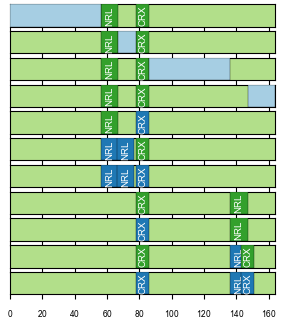

In [7]:
# We reverse the order so that the cartoons are drawn in the same order as the bars above
cartoon_swaps = swaps_activity[
    ~swaps_activity["blocks"].str.match("A,B,C,D,E,F,G|a,b,c,d,e,f,g")
][::-1]
nswaps = len(cartoon_swaps)
fig, ax_list = plt.subplots(
    nrows=nswaps,
    sharex=True,
    sharey=True,
    figsize=plot_utils.get_figsize(0.5, aspect=0.1*nswaps)
)
for ax, (idx, row) in zip(ax_list, cartoon_swaps.iterrows()):
    if re.compile("b").search(row["blocks"]):
        nrl_color = dark_green
    else:
        nrl_color = dark_blue
    if re.compile("d").search(row["blocks"]):
        crx_color = dark_green
    else:
        crx_color = dark_blue
    

    plot_utils.visualize_sequence(
        row["sequence"],
        light_green,
        ewms,
        mu,
        {"CRX": crx_color, "NRL": nrl_color},
        figax=(fig, ax),
    )
    # If a spacer was swapped, draw a light blue box
    match = re.search("[A-Z]", row["blocks"])
    if match:
        block = match[0]
        if block in {"A", "C", "E", "G"}:
            begin, end = block_coords[block]
            ax.axvspan(begin, end, facecolor=light_blue, edgecolor="black", zorder=3)
    
    ax.set_yticks([])
    
plot_utils.save_fig(fig, os.path.join(figures_dir, "inactiveSwapsCartoons"))

Saliency map of the swap that converts.

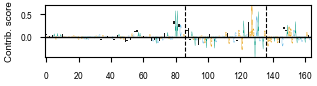

In [8]:
swapped_seq = swaps_activity.loc[
    swaps_activity["blocks"] == "a,b,c,d,E,f,g",
    "sequence"
].squeeze()
hypo, actual, pred = deeplift_utils.saliency_map(swapped_seq, model)
fig, ax = plot_utils.plot_deeplift(
    actual,
    # smoothing=True,
)
# Use the same limits as above
ax.set_ylim(ylims)
# ax.set_yticks(np.arange(-0.025, 0.075, 0.025))
# Show the region swapped
x = [86, 136]
for i in x:
    ax.axvline(i, color="k", linestyle="--")

plot_utils.save_fig(fig, os.path.join(figures_dir, "inactiveSwapSaliencyActual"))

Quantify importance of CRX, NRL, and 119-136 before and after the swap.

,WT,"Swap [86,136)"
NRL,0.228297,0.374043
CRX,1.185422,2.078128
NR1D1,0.000000,3.043243


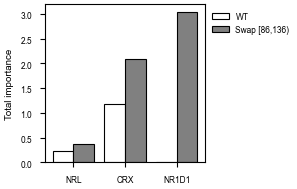

In [9]:
def get_region_importance(row, track):
    return track[row["begin"]:row["end"]].sum()

inactive_coords = {
    tf.split("_")[0]: (start, start+len(ewms[tf.split("_")[0]]))
    for start, tf in inactive_site_map.items()
}
inactive_coords["NR1D1"] = (119, 136)
inactive_coords = pd.DataFrame.from_dict(
    inactive_coords, orient="index", columns=["begin", "end"]
)

region_importance = {}
for seq, name in [[inactive_wt_seq, "WT"], [swapped_seq, "Swap [86,136)"]]:
    _, actual, _ = deeplift_utils.saliency_map(seq, model)
    actual_track = actual.max(axis=0)
    region_importance[name] = inactive_coords.apply(
        get_region_importance, args=(actual_track,), axis=1
    )
    
region_importance = pd.DataFrame(region_importance)
# Zero out the NR1D1 before the swap since there is no NR1D1 and the calculation is from the spacer sequence next to
region_importance.loc["NR1D1", "WT"] = 0

width = 0.4
x = np.arange(len(region_importance))
fig, ax = plt.subplots(figsize=plot_utils.get_figsize(0.3, 1))
for i, (color, name) in enumerate(zip(["white", "grey"], region_importance)):
    ax.bar(
        x + width * i,
        region_importance[name],
        width,
        color=color,
        label=name,
        edgecolor="k",
        linewidth=mpl.rcParams["lines.linewidth"],
    )
    
ax.set_xticks(x + width/2)
ax.set_xticklabels(region_importance.index)
ax.set_ylabel("Total importance")
ax.legend(
    loc="upper left",
    bbox_to_anchor=(1, 1),
    frameon=False,
)
display(region_importance)
plot_utils.save_fig(fig, os.path.join(figures_dir, "inactiveSwapMotifImportance"))

## Sliding experiment

Experimental result.

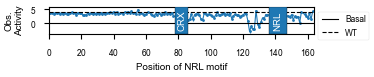

In [16]:
white = (1., 1., 1.)
slide_activity_df = activity_df.set_index("label").join(
    slide_coords,
    how="inner"
)
slide_activity_df = slide_activity_df.sort_values(by="position_moved_to")

fig, ax = plt.subplots(figsize=plot_utils.get_figsize(0.5, aspect=0.1))
ax.errorbar(
    slide_activity_df["position_moved_to"],
    slide_activity_df["expression_log2"],
    yerr=slide_activity_df["sigma"],
    zorder=1,
    fmt="o-"
)
ax.axhline(0, color="k", label="Basal")
ax.axhline(
    slide_activity_df.loc[strong_enhancer_id + "_WT", "expression_log2"].mean(),
    color="k",
    linestyle="--",
    label="WT"
)
fig, ax = plot_utils.visualize_sequence(
    strong_enhancer_wt_seq,
    white,
    ewms,
    mu,
    dark_blue,
    figax=(fig, ax)
)
ax.set_ylabel("Obs.\nActivity")
ax.set_xlabel("Position of NRL motif")
ax.legend(loc="upper left", bbox_to_anchor=(1,1))
plot_utils.save_fig(fig, os.path.join(figures_dir, "strongEnhancerSlideNrl"))

Saliency map lineplot.

In [17]:
slide_activity_nodup = slide_activity_df.drop_duplicates(subset="sequence")
slide_seqs = slide_activity_nodup["sequence"]
hypos = []
actuals = []
actuals_decoded = []
preds = []
for seq in slide_seqs:
    h, a, p = deeplift_utils.saliency_map(seq, model)
    hypos.append(np.expand_dims(h, axis=0))
    actuals.append(np.expand_dims(a, axis=0))
    actuals_decoded.append(np.expand_dims(a.max(axis=0), axis=0))
    preds.append(p)
    
hypos = np.concatenate(hypos, axis=0)
actuals = np.concatenate(actuals, axis=0)
actuals_decoded = np.concatenate(actuals_decoded, axis=0)
preds = np.array(preds)

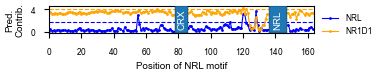

In [18]:
nrl_importance = {}
novel_importance = {}

novel_start = 119
novel_size = 136 - novel_start

nrl_size = len(ewms["NRL"])
for i, variant in slide_activity_nodup.reset_index().iterrows():
    start_pos, fiveprime = variant[["position_moved_to", "is_moved_5prime"]]
    track = actuals_decoded[i]
    # If it is the WT position, store separately
    if fiveprime is np.nan:
        wt_nrl_importance = track[136:136+nrl_size].sum()
        wt_novel_importance = track[novel_start:novel_start+novel_size].sum()
    else:
        start_pos = int(start_pos)
        # Find the NRL site
        if fiveprime:
            nrl_importance[start_pos] = track[start_pos:start_pos+nrl_size].sum()
        else:
            nrl_importance[start_pos] = track[start_pos-nrl_size:start_pos].sum()

        # Find the novel region
        # If NRL is before the novel region, coordinates have shifted
        if start_pos < novel_start:
            novel_importance[start_pos] = track[novel_start+nrl_size:novel_start+nrl_size+novel_size].sum()
        # If NRL is after the novel region, there's no shifting
        elif fiveprime is False:
            novel_importance[start_pos] = track[novel_start:novel_start+novel_size].sum()
        # Otherwise the NRL motif is embedded within the novel motif
        else:
            novel_importance[start_pos] = track[novel_start:start_pos].sum() + track[start_pos+nrl_size:novel_start+nrl_size+novel_size].sum()
            
nrl_importance = pd.Series(nrl_importance)
novel_importance = pd.Series(novel_importance)

fig, ax = plt.subplots(figsize=plot_utils.get_figsize(0.5, aspect=0.1))
ax.plot(
    nrl_importance.index,
    nrl_importance,
    marker="o",
    color="blue",
    label="NRL"
)
ax.axhline(
    wt_nrl_importance,
    color="blue",
    linestyle="--",
)
ax.plot(
    nrl_importance.index,
    novel_importance,
    marker="o",
    color="orange",
    label="NR1D1"
)
ax.axhline(
    wt_novel_importance,
    color="orange",
    linestyle="--",
)
plot_utils.visualize_sequence(
    strong_enhancer_wt_seq,
    white,
    ewms,
    mu,
    dark_blue,
    figax=(fig, ax)
)
ax.set_yticks([0, 4])
ax.set_xlabel("Position of NRL motif")
ax.set_ylabel("Pred.\nContrib.")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
plot_utils.save_fig(fig, os.path.join(figures_dir, "strongEnhancerSlideNrlImportance"))

Zoom in on region.

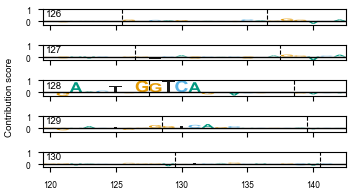

In [20]:
moved_pos = slide_activity_nodup["position_moved_to"].dropna().astype(int)
mask = (moved_pos >= 126) & (moved_pos <= 130)
idx = np.arange(len(moved_pos))[mask]
fig, ax_list = plt.subplots(
    nrows=len(idx),
    figsize=plot_utils.get_figsize(0.5, aspect=0.12*len(idx)),
    sharex=True,
    sharey=True,
)
top = bottom = 0
zoom_start = 120
zoom_end = 143
for i, ax in zip(idx, ax_list):
    plot_utils.plot_deeplift(
        actuals[i, :, zoom_start:zoom_end],
        figax=(fig, ax)
    )
    ax.text(
        0.01, 0.95,
        str(moved_pos.iloc[i]),
        transform=ax.transAxes,
        ha="left", va="top",
    )
    # Show the breakpoint
    breakpoint = moved_pos.iloc[i] - zoom_start
    ax.axvline(
        breakpoint - 0.5,
        color="k",
        linestyle="--"
    )
    ax.axvline(
        breakpoint + nrl_size - 0.5,
        color="k",
        linestyle="--",
    )
    
    # Adjust the limits if appropriate
    b, t = ax.get_ylim()
    if b < bottom:
        bottom = b
    if t > top:
        top = t

ticklabels = np.arange(zoom_start, zoom_end + 1, 5)
ax.set_xticks(ticklabels - zoom_start)
ax.set_xticklabels(ticklabels)
for ax in ax_list:
    ax.set_ylim((bottom, top))
    ax.set_yticks([0, round(top, 1)])
    
fig.text(
    0,
    0.5,
    "Contribution score",
    rotation=90,
    ha="right",
    va="center",
)
fig.tight_layout()
plot_utils.save_fig(fig, os.path.join(figures_dir, "strongEnhancerSlideSaliencyZoom"))

## Figure out what the motif is

FEV_F is occupied at positions [118]
IKZF1_F is occupied at positions [118 125]
MAFB_R is occupied at positions [132]
MYF6_R is occupied at positions [ 51 132 144]
NR1D1_F is occupied at positions [119]
RXRB_F is occupied at positions [133]


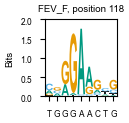

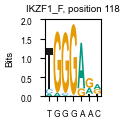

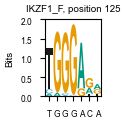

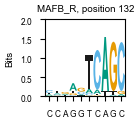

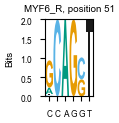

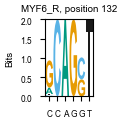

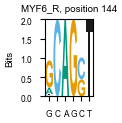

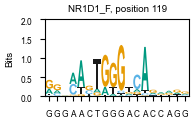

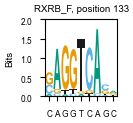

In [21]:
hocomoco = predicted_occupancy.read_pwm_files(
    "/ref/bclab/data/meme/motif_databases.12.23/MOUSE/HOCOMOCOv11_core_MOUSE_mono_meme_format.meme"
).rename(lambda x: x.split("_")[0])
hocomoco_ewms = hocomoco.apply(predicted_occupancy.ewm_from_letter_prob).apply(predicted_occupancy.ewm_to_dict)
occupancy_df = predicted_occupancy.total_landscape(strong_enhancer_wt_seq, hocomoco_ewms, mu)

occupied_in_region = (occupancy_df.loc[117:135] > 0.5).any()
occupied_tfs = occupancy_df.columns[occupied_in_region]
for tf in occupied_tfs:
    occupied_sites = occupancy_df.loc[occupancy_df[tf] > 0.5, tf].index.values
    print(f"{tf} is occupied at positions {occupied_sites}")
    tf, strand = tf.split("_")
    motif = hocomoco[tf]
    # revcomp if necessary
    if strand == "R":
        motif = pd.DataFrame(motif.iloc[::-1, ::-1].values, index=motif.index, columns=motif.columns)
        
    motif_size = len(motif)
    width = plot_utils.get_figsize(0.015 * motif_size)[0]
    for pos in occupied_sites:
        fig, ax = plt.subplots(figsize=(width, 1))
        logomaker.Logo(
            logomaker.transform_matrix(
                motif, from_type="probability", to_type="information"
            ),
            color_scheme="colorblind_safe",
            ax=ax
        )
        ax.set_ylabel("Bits")
        ax.set_ylim((0, 2))
        ax.set_xticks(np.arange(0, motif_size))
        ax.set_xticklabels(strong_enhancer_wt_seq[pos:pos+motif_size])
        ax.set_title(f"{tf}_{strand}, position {pos}")
        plot_utils.save_fig(fig, os.path.join(figures_dir, f"motif_{tf}_{strand}_{pos}"))